# Initial settings

directoryのセットアップ

In [1]:
import os
import glob

cwd = os.getcwd()
user = 'keetane'
project = 'ruxolitinib'
wd = os.path.join(cwd, '1_wd', user, project)
input_dir    = os.path.join(wd, 'input');    os.makedirs(input_dir, exist_ok=True)
results_dir  = os.path.join(wd, 'results');  os.makedirs(results_dir, exist_ok=True)
results_log  = os.path.join(results_dir, 'log');  os.makedirs(results_log, exist_ok=True)
toml_dir     = os.path.join(wd, 'toml');     os.makedirs(toml_dir, exist_ok=True)
toml_path = os.path.join(toml_dir, "sampling.toml")
sampling_log = os.path.join(results_dir, 'log'); os.makedirs(sampling_log, exist_ok=True)
# priors_dir = os.path.join(cwd, 'priors')
# model_list = glob.glob(priors_dir + '/*.prior')[2:-1]   # reinvent, linkinvent, libinventは除外
# model_name = [x.split('/')[-1].split('.')[0][8:] for x in model_list]
# model_name
input_dir

'/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input'

Mol2Molのモデルの確認とdict化

In [2]:
# mol2mol modelのパスとモデル名のリストからdictを作成
model_path_list = glob.glob(cwd+'/priors/mol2mol*.prior') 
model_name_list = [os.path.basename(path).split('.')[0][8:] for path in model_path_list]  # reinvent, libinvent, linkinventを除外
model_dict = dict(zip(model_name_list, model_path_list))

# pubchem_ecfp4をappend
model_dict['pubchem']=glob.glob(cwd+'/priors/*.prior')[2]
model_dict


{'mmp': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_mmp.prior',
 'high_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_high_similarity.prior',
 'medium_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_medium_similarity.prior',
 'similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_similarity.prior',
 'scaffold_generic': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold_generic.prior',
 'scaffold': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold.prior',
 'pubchem': '/Users/keetane/Documents/apps/REINVENT4/priors/pubchem_ecfp4_with_count_with_rank_reinvent4_dict_voc.prior'}

input file=ruxolitinibの準備

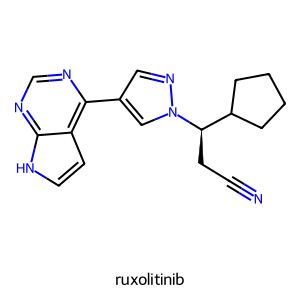

In [3]:
import pandas as pd
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Draw

# ruxolitinibのSMILESをPubChemから取得
parent = project 
compound = pcp.get_compounds(parent, 'name')
rxt_smiles = compound[0].isomeric_smiles

# rxt_smilesをparent.smiとして保存
with open(f'{input_dir}' + "/parent.smi", "w") as f:
    f.write(rxt_smiles) 

# rxt_smilesを描画
Draw.MolToImage(Chem.MolFromSmiles(rxt_smiles), size=(300, 300), legend=parent)

tomlファイル作成とreinventの実行用関数

In [37]:
import subprocess as sp
def reinvent(model, # input model_dict.keys()
              input_smiles=input_dir+'/parent.smi', # default {input_dir}/parent.smi
                num_smiles=10000,
                  device='mps', 
                    sample_strategy='beamsearch',
                      temperature=1.0):
    if model.split('/')[-1].split('.')[0][:8]=='mol2mol_':
        model_name = model.split('/')[-1].split('.')[0][8:] # mol2mol_の後ろの文字列を取得
    else:
        model_name = model.split('/')[-1].split('.')[0][:13] # ==pubchem_ecfp4
    toml = f"""
run_type = "sampling"
device = "{device}"
json_out_config = "{results_log}_sampling.json"

[parameters]
model_file = "{model}"
output_file = "{results_dir}/{parent}_{model_name}.csv"
num_smiles = "{num_smiles}"
unique_molecules = true
randomize_smiles = true
smiles_file = "{input_smiles}"
sample_strategy = "{sample_strategy}"
temperature = "{temperature}"
"""
    with open(toml_path, "w") as f:
        f.write(toml)
    log_file = os.path.join(sampling_log, "sampling.log")
    cmd = ['reinvent', '-l', log_file, toml_path]
    sp.call(cmd)

reinvent関数のテスト実行

In [38]:
model_dict

{'mmp': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_mmp.prior',
 'high_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_high_similarity.prior',
 'medium_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_medium_similarity.prior',
 'similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_similarity.prior',
 'scaffold_generic': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold_generic.prior',
 'scaffold': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold.prior',
 'pubchem': '/Users/keetane/Documents/apps/REINVENT4/priors/pubchem_ecfp4_with_count_with_rank_reinvent4_dict_voc.prior'}

In [39]:
model_name = 'medium_similarity'
reinvent(model=model_dict[model_name],
          num_smiles=10000,
          sample_strategy='beamsearch',
        #   input_smiles=os.path.join(input_dir, "parent.smi"),
        #   device='mps',
        #   temperature=1.0
          )
pd.read_csv(os.path.join(results_dir, f"{parent}_{model_name}.csv")).head()

Empty DataFrame
Columns: [SMILES, Input_SMILES, Tanimoto, NLL]
Index: []

# Sampling molecules for all models

全モデルについて10000分子を生成し、ファイルを結合

In [ ]:
# 全モデルでreinventを実行
for model in model_dict.values():
    reinvent(model,
              num_smiles=10000,
              sample_strategy='beamsearch',
            #   input_smiles=os.path.join(input_dir, "parent.smi"),
            #   device='mps',
            #   temperature=1.0
              )


python(5758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


全てのモデルの結果を結合

In [42]:
glob.glob(results_dir + f"/{parent}_*.csv")

['/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_all_model.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_high_similarity.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_scaffold_generic.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_pubchem_ecfp4.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_mmp.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_scaffold.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_similarity.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_medium_similarity.csv']

In [51]:
# 結果の読み込みと結合
# 出力結果のリストを作成
results_list = glob.glob(results_dir + f"/{parent}_*.csv")

# 結合ファイルが存在する場合は除外
all_model = f'{results_dir}/{parent}_all_model.csv'
results_list = [item for item in results_list if item != all_model]

# 出力結果リストからloopでdataframeを取得し結合、保存
df = []
for csv in results_list:
    temp = pd.read_csv(csv, sep=',')
    temp['model'] = csv.split('/')[-1].split('.')[0][len(parent)+1:]
    df.append(temp)
df = pd.concat(df, ignore_index=True)
df.to_csv(f'{results_dir}/{parent}_all_model.csv', index=False)
df[-5:]


SMILES  \
49852  CC(C)CS(=O)(=O)NC[C@H](C1CCCC1)n1ncc(-c2ncnc3[...   
49853  N#CC[C@H](C1CCCCC1)n1ccc(-c2ncnc3[nH]c(-c4ccc(...   
49854  Cc1ccc(S(=O)(=O)n2cc(-c3cnn(C(CC#N)C4CCCC4)c3)...   
49855  CS(=O)(=O)NC(=O)CCC(C1CCCC1)n1ccc(-c2ccnc3[nH]...   
49856  CS(=O)(=O)NC(=O)CC(C1CCCCC1)n1ncc(-c2ccnc3[nH]...   

                                       Input_SMILES  Tanimoto    NLL  \
49852  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.471698  12.56   
49853  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.443478  12.56   
49854  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.466019  12.59   
49855  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.385321  12.59   
49856  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.390909  12.65   

            model  
49852  similarity  
49853  similarity  
49854  similarity  
49855  similarity  
49856  similarity

重複の検出

7677 was duplicated
5254 molecules were unique


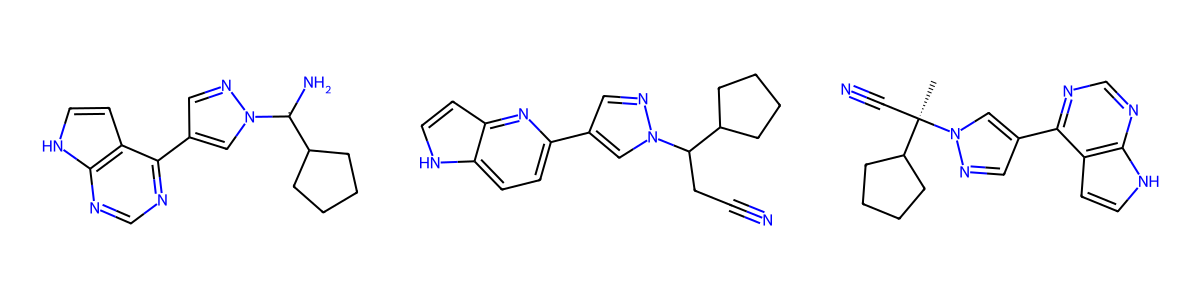

In [75]:
# SMILESの正規化
def duplicant_detector(smiles):
    mol = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    return canonical_smiles

df['canonical_smiles'] = df.SMILES.map(lambda x : duplicant_detector(x))
# 重複の検出
df_dup = df[df.duplicated(subset='canonical_smiles')]
print(str(str(len(df_dup)) + ' was duplicated'))
print(str(len(df_dup.canonical_smiles.unique())) + ' molecules were unique')
Draw.MolsToGridImage(
    [mol for mol in df_dup.SMILES.map(lambda x : Chem.MolFromSmiles(x)).sample(3)],
    subImgSize=(400,300)
)

descriptorの計算

In [91]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem 
from rdkit.Chem import rdMolDescriptors 

def calculate_rdkit_descriptors(df, smiles_column='SMILES'):
    descriptor_functions = {
        'MW': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'HBA': Lipinski.NumHAcceptors,
        'HBD': Lipinski.NumHDonors,
        'Rotatable_Bonds': Descriptors.NumRotatableBonds,
        'Amide_Count': AllChem.CalcNumAmideBonds,
        'Ring_Count': rdMolDescriptors.CalcNumRings,
        'Aromatic_Ring_Count': rdMolDescriptors.CalcNumAromaticRings,
        'Fraction_CSP3': rdMolDescriptors.CalcFractionCSP3,
    }

    def smiles_to_mol(smiles):
        if pd.isna(smiles):
            return None
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            # AssignStereoChemistry はこのエラーのために呼び出さない
            # Chem.AssignStereoChemistry(mol, cleanIt=True, force=True) 
            return mol
        except Exception as e:
            print(f"SMILESパース例外: '{smiles}' - {e}")
            return None

    def count_chiral_centers_fallback(mol):
        """
        AssignStereoChemistryが使えない場合のキラル中心数フォールバック関数。
        SMILESから直接エンコードされたキラル中心のみをカウントする傾向があります。
        """
        if mol is None:
            return 0
        
        num_chiral = 0
        for atom in mol.GetAtoms():
            # アトムに立体情報が設定されているか確認
            # CHI_UNSPECIFIED (0) 以外であれば、立体中心として認識されている
            if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                # この原子が四面体中心として妥当か確認 (結合数が4など)
                # より厳密なチェックが必要な場合もあるが、ここではシンプルに
                if atom.GetDegree() >= 3: 
                    num_chiral += 1
        return num_chiral

    df['mol_object'] = df[smiles_column].apply(smiles_to_mol)

    for desc_name, desc_func in descriptor_functions.items():
        df[desc_name] = df['mol_object'].apply(
            lambda mol: desc_func(mol) if mol is not None else None
        )
    
    # キラリティの有無を判定するディスクリプタを追加
    # フォールバック関数を使用
    df['NumChiralCenters'] = df['mol_object'].apply(
        lambda mol: count_chiral_centers_fallback(mol) if mol is not None else 0
    )
    # df['IsChiral'] = df['NumChiralCenters'].apply(lambda num: num > 0) # この行を削除
    
    df.drop(columns=['mol_object'], inplace=True) 
    
    return df


# csvを読み込み
csv_path = f"{results_dir}/{parent}_all_model.csv"
df = pd.read_csv(csv_path)

#　計算結果を保存
df = calculate_rdkit_descriptors(df)
df.to_csv(f'{results_dir}/{parent}_all_desc.csv', index=False)
df.head()

SMILES  \
0       N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
1  N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
2       N#CCC(C1CCOCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
3         N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
4   N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   

                                   Input_SMILES  Tanimoto   NLL  \
0  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.957746  1.54   
1  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.957746  2.69   
2  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.805195  2.93   
3  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.913043  3.01   
4  N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1  0.957746  3.12   

             model       MW     LogP   TPSA  HBA  HBD  Rotatable_Bonds  \
0  high_similarity  320.400  3.85648  83.18    5    1                4   
1  high_similarity  320.400  3.85648  83.18    5    1                4   
2  high_similarity  322.372  2.70278  92.41    6    1                4   
3  high_similarity  292.346  3.07628  83.18    5    1                4   
4  high_similarity  320.400  3.85648  83.18    5    1                4   

   Amide_Count  Ring_Count  Aromatic_Ring_Count  Fraction_CSP3  \
0            0           4                    3       0.444444   
1            0           4                    3       0.444444   
2            0           4                    3       0.411765   
3            0           4                    3       0.375000   
4            0           4                    3       0.444444   

   NumChiralCenters  
0                 0  
1                 1  
2                 0  
3                 0  
4                 1

In [24]:
df.model.unique()

array(['high_similarity', 'scaffold_generic', 'pubchem_ecfp4', 'mmp',
       'scaffold', 'similarity'], dtype=object)

# Visualizaion of Chemical Space

各Descriptorについてviolin plot


--- バイオリンプロット（各パラメータについてモデル別） ---


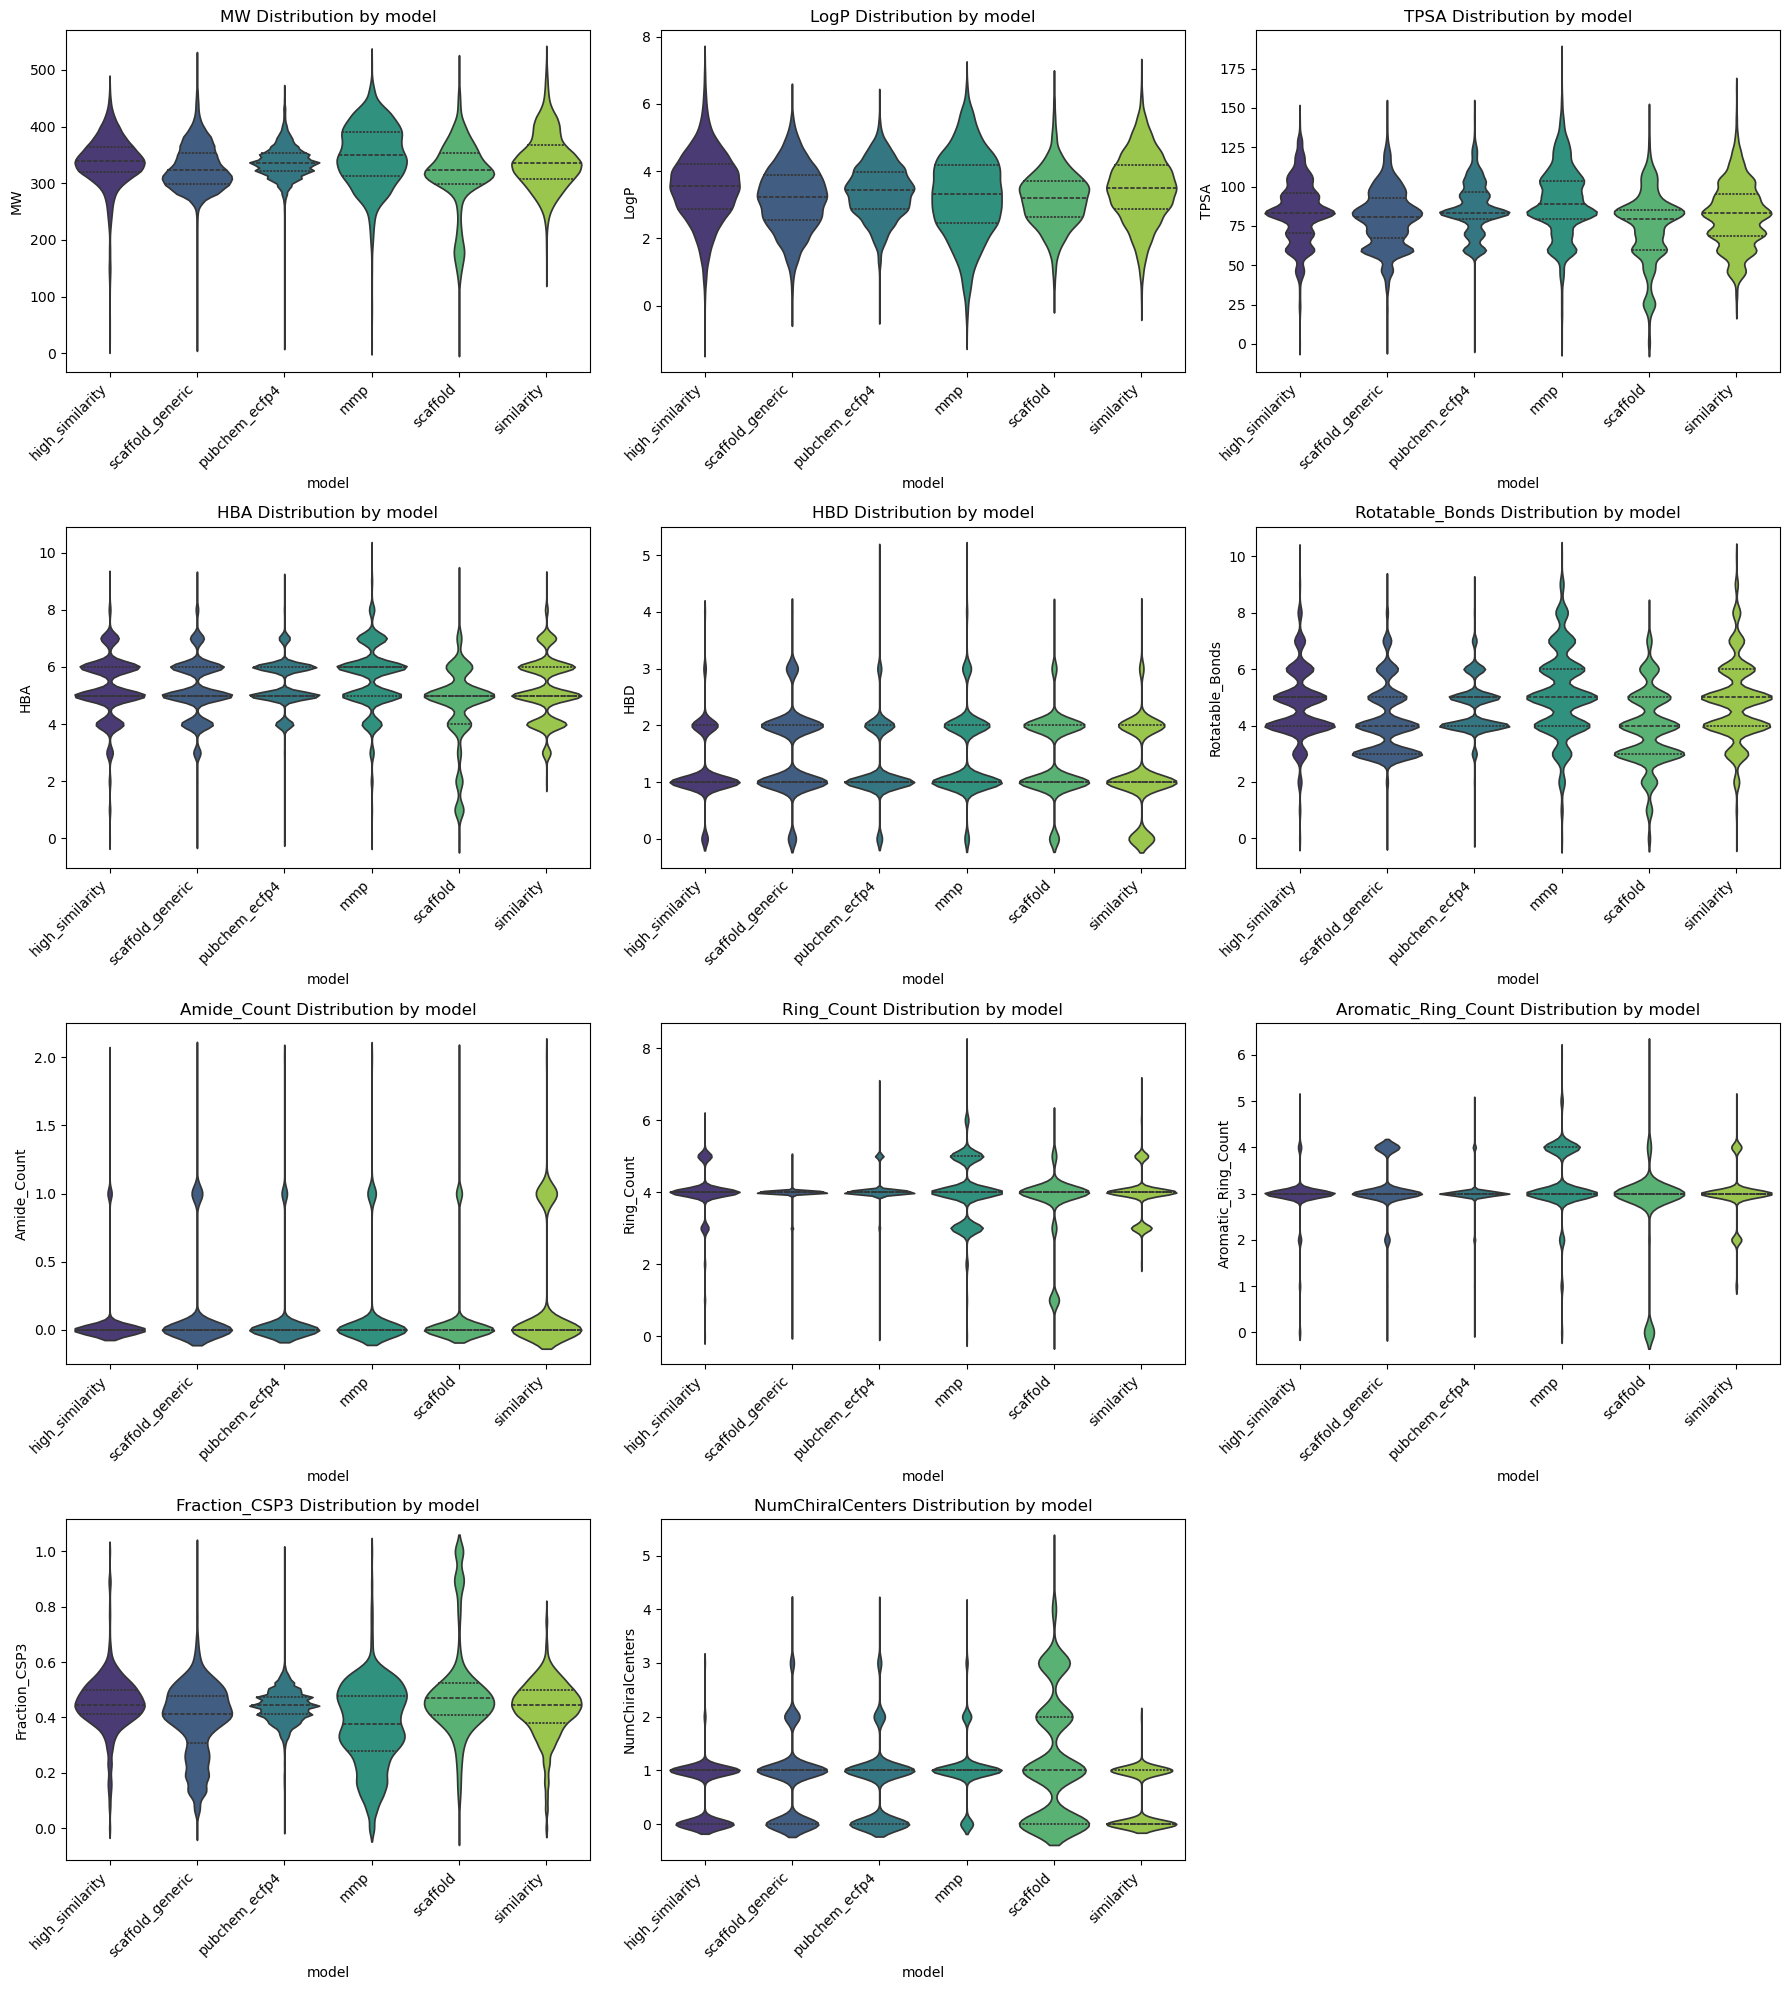

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings # warningsモジュールをインポート

# FutureWarningを無視する設定
warnings.filterwarnings("ignore", category=FutureWarning)

def visualize_chemical_space_distributions(df, model_column='model'):
    descriptors_to_plot = [
        'MW', 'LogP', 'TPSA', 'HBA', 'HBD',
        'Rotatable_Bonds', 'Amide_Count', 'Ring_Count',
        'Aromatic_Ring_Count', 'Fraction_CSP3', 'NumChiralCenters'
    ]

    print("\n--- バイオリンプロット（各パラメータについてモデル別） ---")
    num_plots = len(descriptors_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    if num_plots == 0:
        print("警告: プロットする記述子が指定されていません。")
        return

    plt.figure(figsize=(num_cols * 6, num_rows * 5))

    for i, desc in enumerate(descriptors_to_plot):
        plt.subplot(num_rows, num_cols, i + 1)
        if desc not in df.columns:
            print(f"警告: カラム '{desc}' がDataFrameに存在しません。スキップします。")
            continue
        
        if df[desc].isnull().all():
            print(f"警告: カラム '{desc}' に有効なデータがありません（全てNaN）。スキップします。")
            continue

        sns.violinplot(data=df, x=model_column, y=desc, palette="viridis", inner="quartile")
        plt.title(f'{desc} Distribution by {model_column}')
        plt.xlabel(model_column)
        plt.ylabel(desc)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

df = pd.read_csv(f'{results_dir}/{parent}_all_desc.csv')
visualize_chemical_space_distributions(df)


Tanimoto係数とNLLをscatter plot

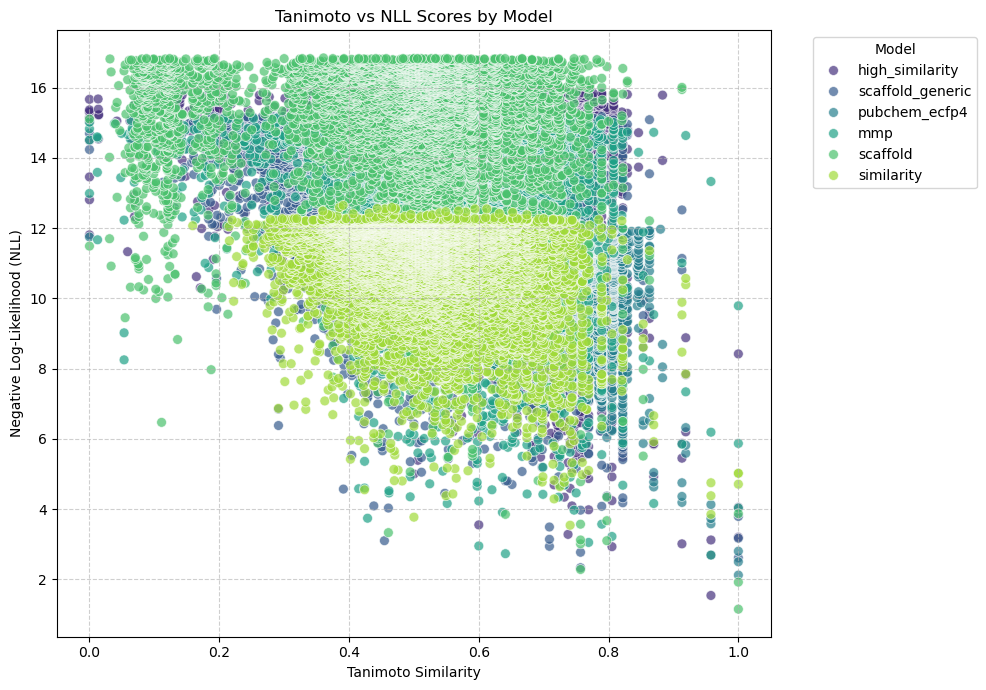

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_tanimoto_nll_scatterplot(df):
    # 必要なカラムが存在するか確認
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。")
            return

    plt.figure(figsize=(10, 7)) # プロットのサイズを設定

    # 散布図の作成
    # hue='model' で 'model' カラムの値に基づいて色分けされます。
    sns.scatterplot(data=df, x='Tanimoto', y='NLL', hue='model', palette='viridis', s=50, alpha=0.7)

    plt.title('Tanimoto vs NLL Scores by Model') # タイトル
    plt.xlabel('Tanimoto Similarity') # x軸ラベル
    plt.ylabel('Negative Log-Likelihood (NLL)') # y軸ラベル
    plt.grid(True, linestyle='--', alpha=0.6) # グリッドを追加
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') # 凡例をプロットの外に配置
    plt.tight_layout() # レイアウトを調整してラベルが重ならないようにする
    plt.show()
create_tanimoto_nll_scatterplot(df)

トレリスで散布図を表示


--- トレリスプロット（Tanimoto vs NLL スコア、モデル別） ---


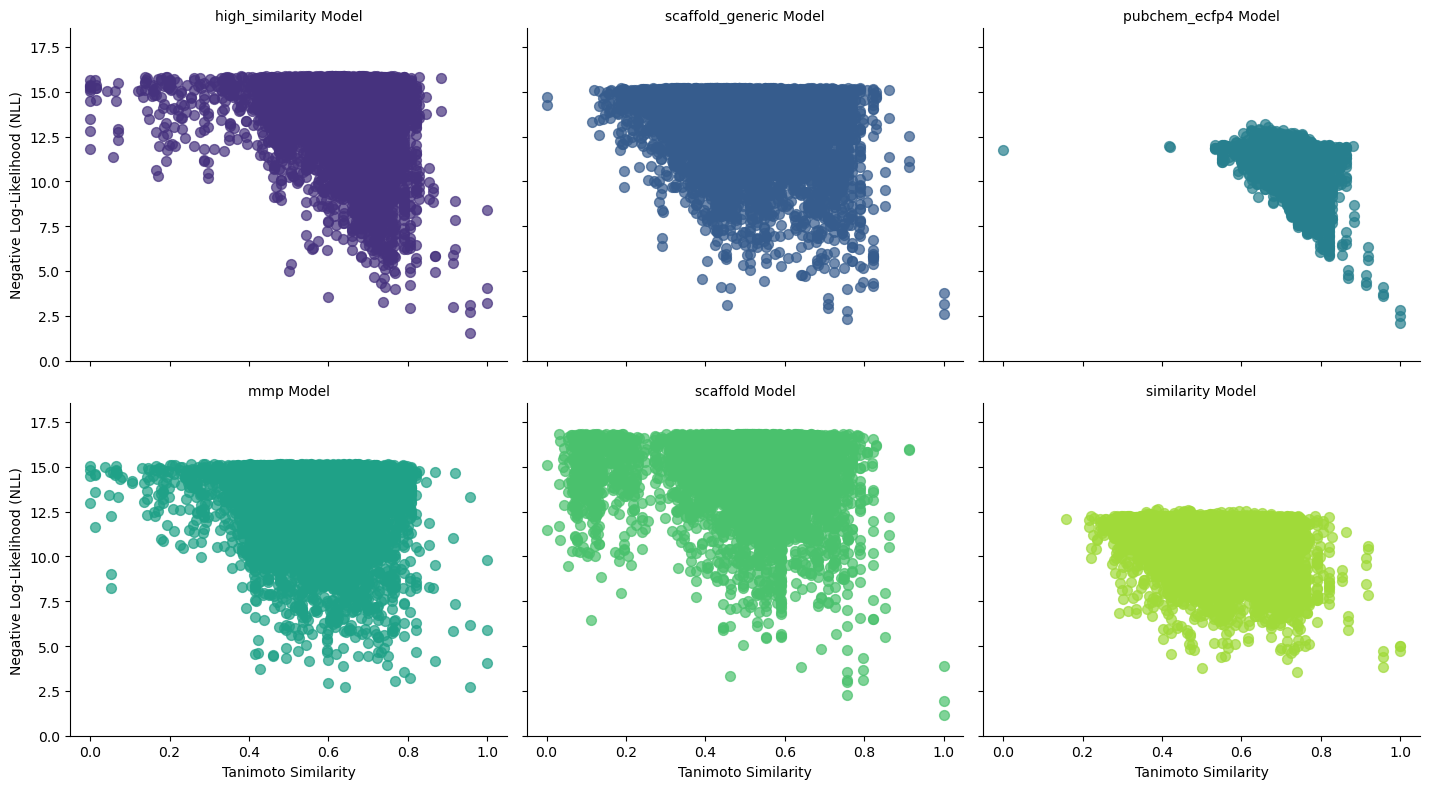

In [69]:
# FutureWarningを無視する設定
warnings.filterwarnings("ignore", category=FutureWarning)

def create_tanimoto_nll_trellis_plot(df):
    """
    TanimotoとNLLのスコアをモデルの値ごとに色分けしたトレリス散布図を作成します。

    Args:
        df (pd.DataFrame): 'Tanimoto', 'NLL', 'model' カラムを含むDataFrame。
    """
    
    # 必要なカラムが存在するか確認
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。トレリスプロットを生成できません。")
            return

    # DataFrameが空でないか、または必要なデータが十分に存在するかを確認
    if df.empty or df['Tanimoto'].isnull().all() or df['NLL'].isnull().all():
        print("警告: グラフ描画に必要なデータが不足しているか、全て欠損値です。トレリスプロットを生成できません。")
        return

    print("\n--- トレリスプロット（Tanimoto vs NLL スコア、モデル別） ---")
    
    # FacetGrid を使用してトレリスプロットを作成
    # col='model' で 'model' カラムの値に基づいて各サブプロットが作成されます。
    # col_wrap は1行あたりのサブプロット数です。
    # height は各サブプロットの高さ、aspect はアスペクト比です。
    g = sns.FacetGrid(df, col='model', col_wrap=3, height=4, aspect=1.2, palette='viridis', hue='model')

    # 各サブプロットに散布図を描画
    # plt.scatter を map メソッドに渡します。
    g.map(plt.scatter, 'Tanimoto', 'NLL', alpha=0.7, s=50)

    # タイトルと軸ラベルの設定
    # set_axis_labels は全サブプロットの軸ラベルを設定します。
    # set_titles は各サブプロットのタイトルを設定します。
    g.set_axis_labels('Tanimoto Similarity', 'Negative Log-Likelihood (NLL)')
    g.set_titles(col_template='{col_name} Model') # '{col}' を '{col_name}' に変更    
    # 凡例はFacetGridが自動的に設定してくれることが多いですが、
    # 明示的に追加する場合は add_legend() を使用します。
    # hue を指定しているため、通常は自動で凡例が表示されます。
    # g.add_legend(title='Model') 

    # 必要に応じてY軸の範囲を調整
    g.set(ylim=(0, df['NLL'].max() * 1.1)) # NLLの最大値の1.1倍を上限とする

    plt.tight_layout() # レイアウトを調整して、サブプロットやタイトルが重ならないようにします。
    plt.show() # プロットを表示します。
    
create_tanimoto_nll_trellis_plot(df)

箱ひげ図とバイオリンプロットで比較

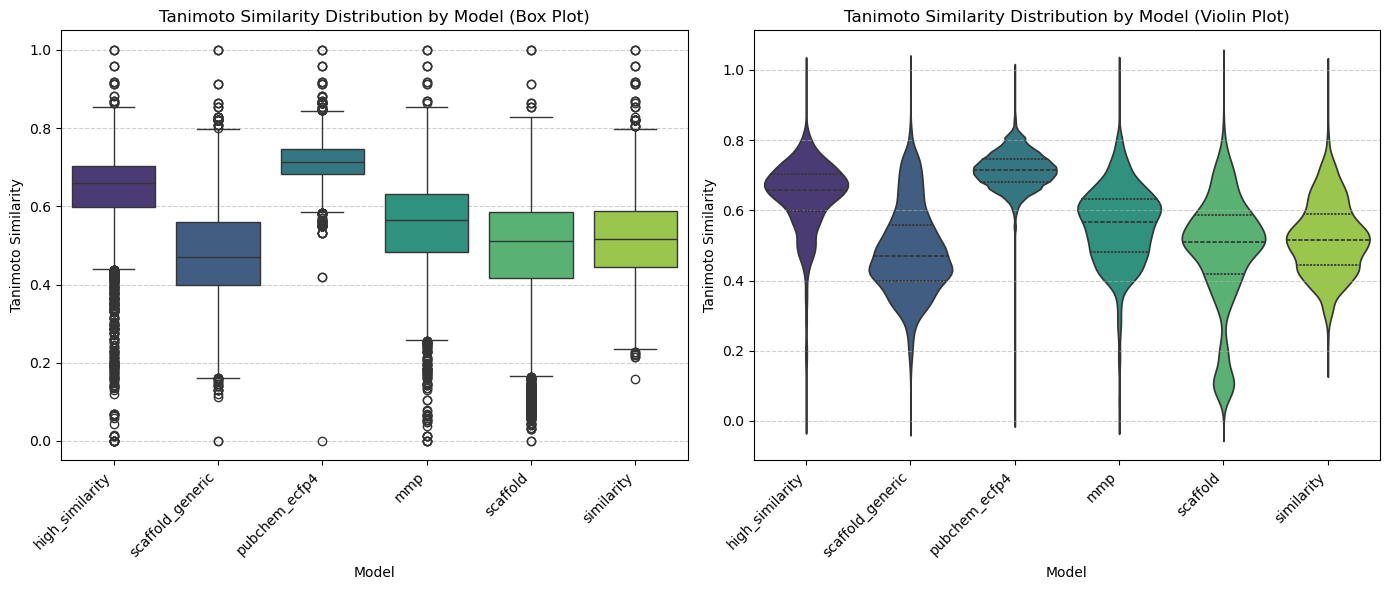

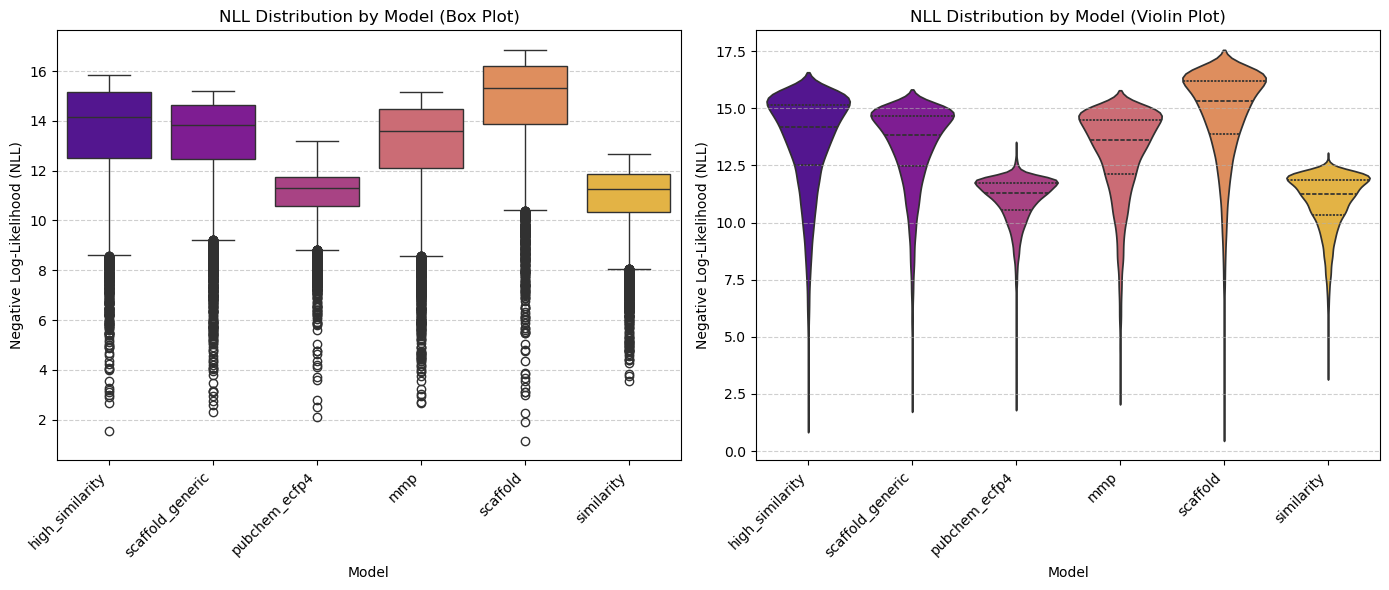

In [71]:
def create_box_violin_plots(df):
    """
    TanimotoとNLLスコアのモデルごとの箱ひげ図とバイオリンプロットを作成します。

    Args:
        df (pd.DataFrame): 'Tanimoto', 'NLL', 'model' カラムを含むDataFrame。
    """
    
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。プロットを生成できません。")
            return

    if df.empty or df['Tanimoto'].isnull().all() or df['NLL'].isnull().all():
        print("警告: グラフ描画に必要なデータが不足しているか、全て欠損値です。プロットを生成できません。")
        return

    # Tanimotoスコアの箱ひげ図とバイオリンプロット
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # 1行2列の1番目のサブプロット
    sns.boxplot(data=df, x='model', y='Tanimoto', palette='viridis')
    plt.title('Tanimoto Similarity Distribution by Model (Box Plot)')
    plt.xlabel('Model')
    plt.ylabel('Tanimoto Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2) # 1行2列の2番目のサブプロット
    sns.violinplot(data=df, x='model', y='Tanimoto', palette='viridis', inner="quartile")
    plt.title('Tanimoto Similarity Distribution by Model (Violin Plot)')
    plt.xlabel('Model')
    plt.ylabel('Tanimoto Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # NLLスコアの箱ひげ図とバイオリンプロット
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='model', y='NLL', palette='plasma')
    plt.title('NLL Distribution by Model (Box Plot)')
    plt.xlabel('Model')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x='model', y='NLL', palette='plasma', inner="quartile")
    plt.title('NLL Distribution by Model (Violin Plot)')
    plt.xlabel('Model')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
    
create_box_violin_plots(df)


# Scaffold/MMP analysis

Ruxolitinibについて解析

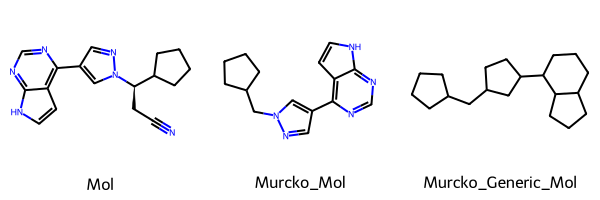

In [4]:
import pandas as pd
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools # PandasToolsをインポート

# ruxolitinibのSMILESをPubChemから取得
parent = 'ruxolitinib' # project変数の代わりに直接文字列を代入
compound = pcp.get_compounds(parent, 'name')
rxt_smiles = compound[0].isomeric_smiles

# SMILESをDataFrameに格納
df_rux = pd.DataFrame({'SMILES': [rxt_smiles], 'Name': [parent]})

# RDKit Molオブジェクトカラムを追加 (元の分子)
PandasTools.AddMoleculeColumnToFrame(df_rux, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)

# Bemis-Murcko ScaffoldのSMILESカラムとMolオブジェクトカラムを追加
PandasTools.AddMurckoToFrame(df_rux, molCol='Mol', MurckoCol='Murcko_SMILES', Generic=False)
df_rux['Murcko_Mol'] = df_rux['Murcko_SMILES'].apply(Chem.MolFromSmiles)

# Murcko_generic ScaffoldのSMILESカラムとMolオブジェクトカラムを追加
PandasTools.AddMurckoToFrame(df_rux, molCol='Mol', MurckoCol='Murcko_Generic_SMILES', Generic=True)
df_rux['Murcko_Generic_Mol'] = df_rux['Murcko_Generic_SMILES'].apply(Chem.MolFromSmiles)

columns = ['Mol', 'Murcko_Mol', 'Murcko_Generic_Mol']
Draw.MolsToGridImage(df_rux[columns].iloc[0], legends=columns)

all_desc.csvのデータに対してMurcko_Molを発生

In [5]:
# REINVENT4の出力CSVファイルを読み込む
generated_molecules_df = pd.read_csv(f'{results_dir}/{parent}_all_desc.csv', sep=',')

# Molオブジェクトカラムを追加
PandasTools.AddMoleculeColumnToFrame(generated_molecules_df, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)

# Bemis-Murcko ScaffoldのSMILESカラムとMolオブジェクトカラムを追加
PandasTools.AddMurckoToFrame(generated_molecules_df, molCol='Mol', MurckoCol='Murcko_SMILES', Generic=False)
# None値が含まれる可能性があるため、エラー回避のためにlambda式で処理
generated_molecules_df['Murcko_Mol'] = generated_molecules_df['Murcko_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)

# Murcko_generic ScaffoldのSMILESカラムとMolオブジェクトカラムを追加
PandasTools.AddMurckoToFrame(generated_molecules_df, molCol='Mol', MurckoCol='Murcko_Generic_SMILES', Generic=True)
generated_molecules_df['Murcko_Generic_Mol'] = generated_molecules_df['Murcko_Generic_SMILES'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None)


# 新しく追加されたカラムを含むデータフレームのheadを表示
display(generated_molecules_df[['SMILES', 'Mol', 'Murcko_SMILES', 'Murcko_Mol', 'Murcko_Generic_SMILES', 'Murcko_Generic_Mol']].head())

SMILES  \
0       N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
1  N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
2       N#CCC(C1CCOCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
3         N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   
4   N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1   

                                             Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x1795c8200>   
1  <rdkit.Chem.rdchem.Mol object at 0x1795c8270>   
2  <rdkit.Chem.rdchem.Mol object at 0x1795c82e0>   
3  <rdkit.Chem.rdchem.Mol object at 0x1795c8350>   
4  <rdkit.Chem.rdchem.Mol object at 0x1795c83c0>   

                           Murcko_SMILES  \
0  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
1  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   
2  c1nc(-c2cnn(CC3CCOCC3)c2)c2cc[nH]c2n1   
3    c1nc(-c2cnn(CC3CCC3)c2)c2cc[nH]c2n1   
4  c1nc(-c2cnn(CC3CCCCC3)c2)c2cc[nH]c2n1   

                                      Murcko_Mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x324bdf530>   
1  <rdkit.Chem.rdchem.Mol object at 0x324bdf5a0>   
2  <rdkit.Chem.rdchem.Mol object at 0x32db202e0>   
3  <rdkit.Chem.rdchem.Mol object at 0x3429f5d90>   
4  <rdkit.Chem.rdchem.Mol object at 0x3429f5e00>   

               Murcko_Generic_SMILES  \
0  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   
1  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   
2  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   
3    C1CC(CC2CCC(C3CCCC4CCCC43)C2)C1   
4  C1CCC(CC2CCC(C3CCCC4CCCC43)C2)CC1   

                              Murcko_Generic_Mol  
0  <rdkit.Chem.rdchem.Mol object at 0x36b9c9230>  
1  <rdkit.Chem.rdchem.Mol object at 0x36b9c92a0>  
2  <rdkit.Chem.rdchem.Mol object at 0x3769d03c0>  
3  <rdkit.Chem.rdchem.Mol object at 0x3769d05f0>  
4  <rdkit.Chem.rdchem.Mol object at 0x3769d0660>

## Scaffold analysis

Scaffoldの出現頻度をモデルごとに積み上げ棒グラフで描画

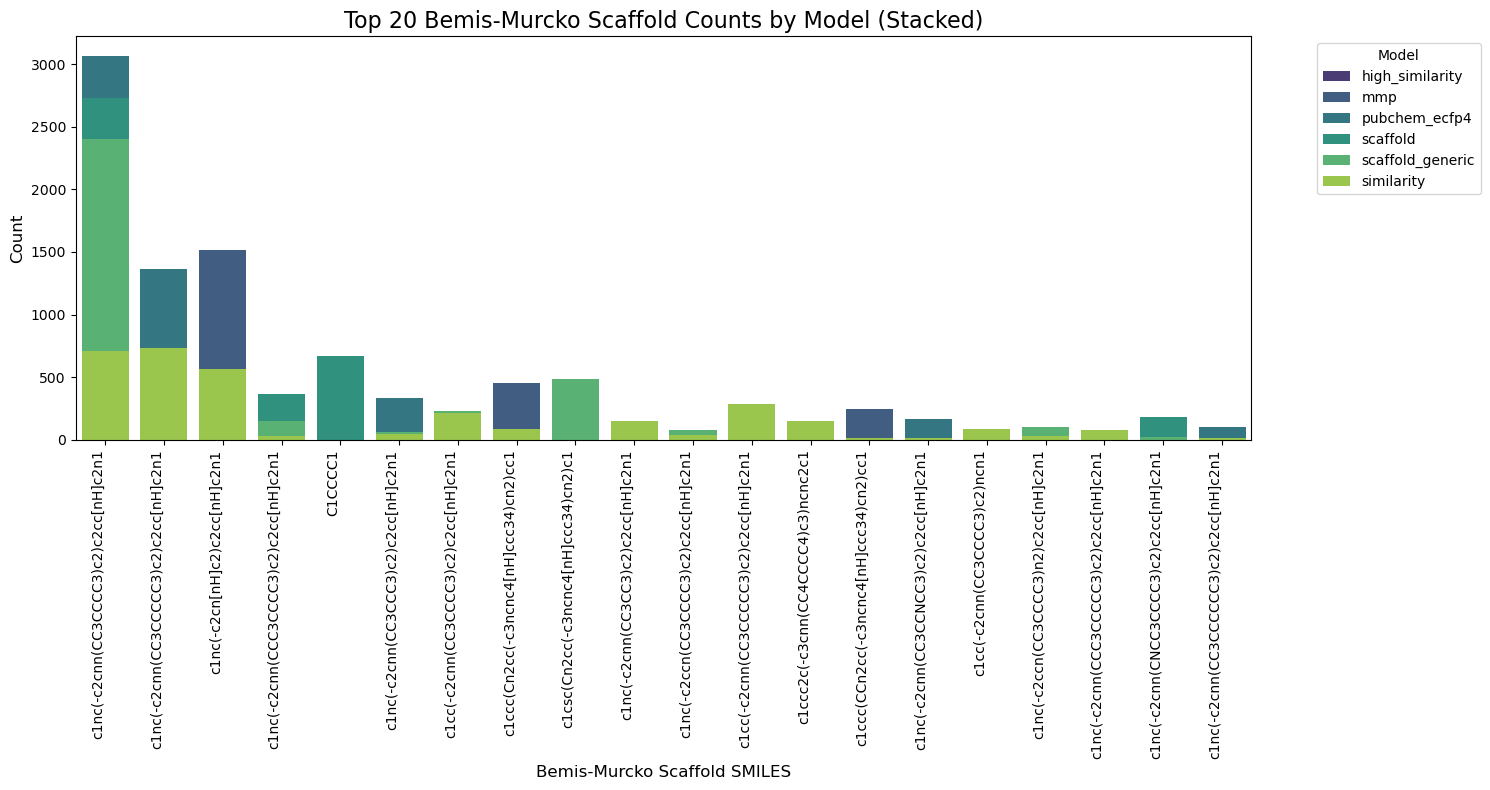


--- Top 20 Bemis-Murcko Scaffold Structures ---


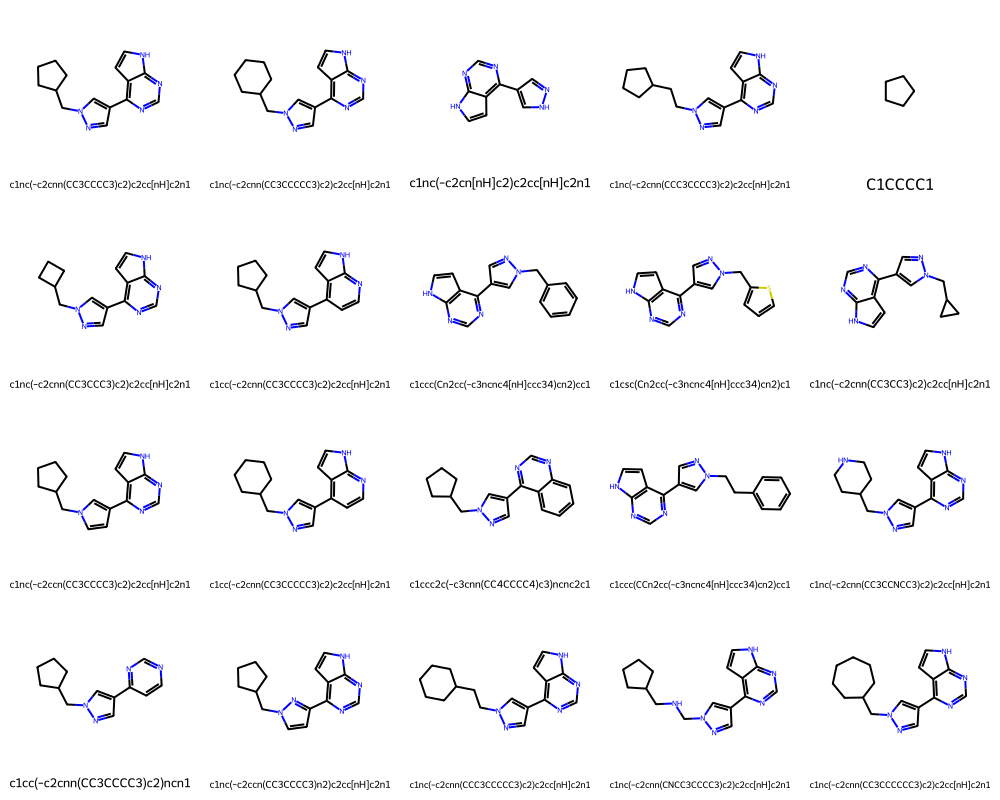

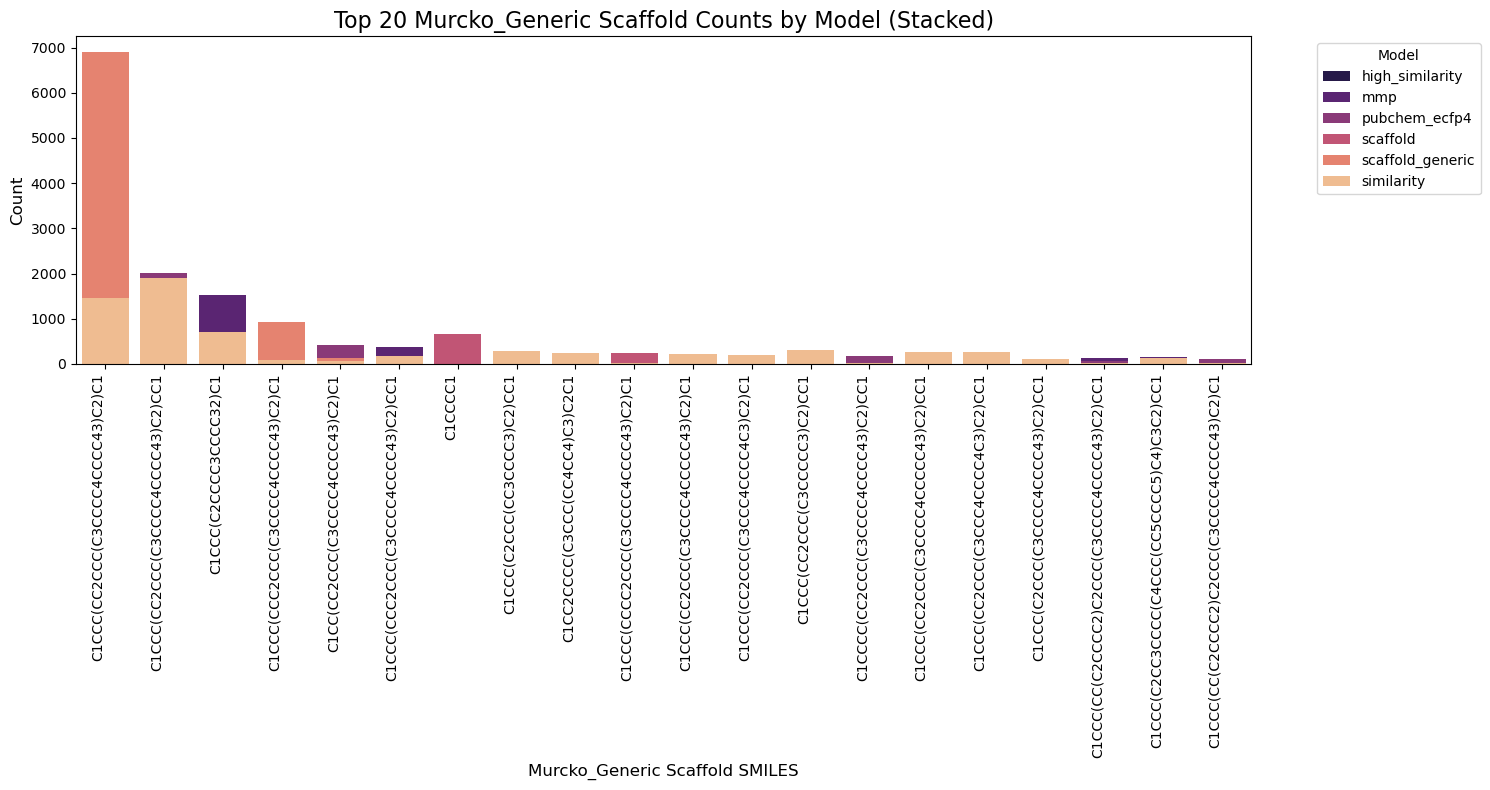


--- Top 20 Murcko_Generic Scaffold Structures ---


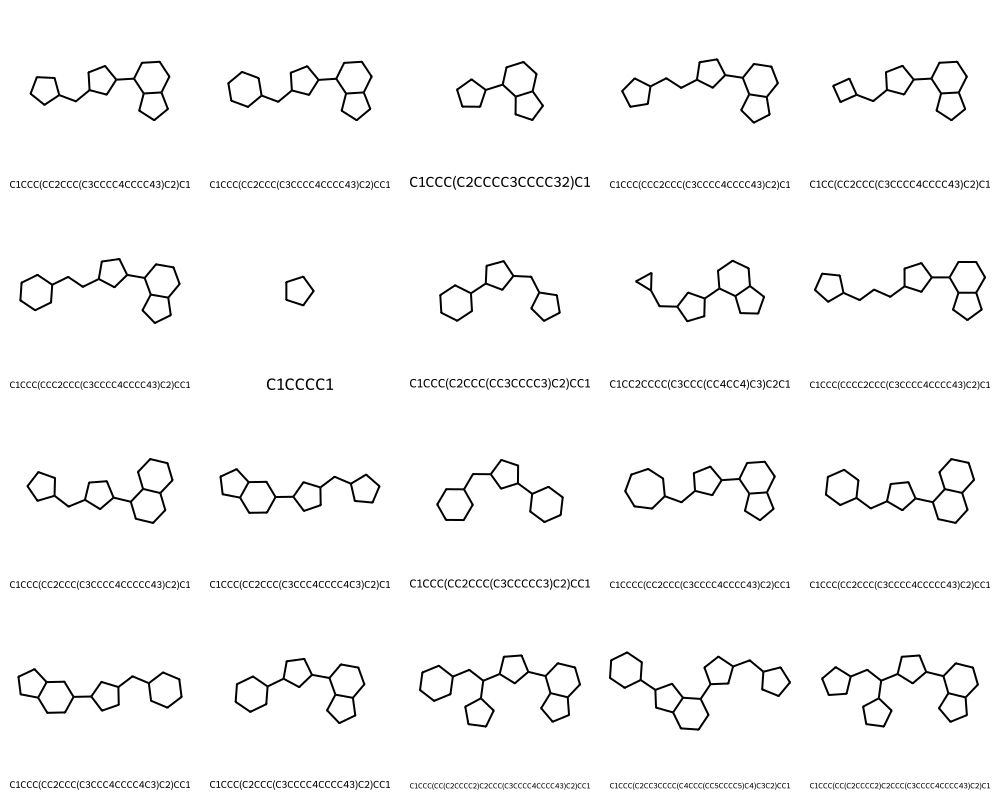

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# --- Bemis-Murcko Scaffoldの頻度とモデルごとの積み上げ棒グラフ ---

# Bemis-Murcko ScaffoldのSMILESとモデルでグループ化し、カウント
bemis_murcko_model_counts = generated_molecules_df.groupby(['Murcko_SMILES', 'model']).size().reset_index(name='Count')
bemis_murcko_model_counts = bemis_murcko_model_counts.dropna(subset=['Murcko_SMILES'])

# 全体の出現回数に基づいて上位20の足場を特定
bemis_total_counts_series = bemis_murcko_model_counts.groupby('Murcko_SMILES')['Count'].sum()
top_n_scaffolds_bemis = bemis_total_counts_series.nlargest(20).index.tolist()

# 上位の足場のみにフィルタリングし、ソート順を保持
# .copy() を追加して明示的にコピーを作成
bemis_murcko_model_counts_top = bemis_murcko_model_counts[bemis_murcko_model_counts['Murcko_SMILES'].isin(top_n_scaffolds_bemis)].copy()
bemis_murcko_model_counts_top['Murcko_SMILES'] = pd.Categorical(bemis_murcko_model_counts_top['Murcko_SMILES'], categories=top_n_scaffolds_bemis, ordered=True)
bemis_murcko_model_counts_top = bemis_murcko_model_counts_top.sort_values(['Murcko_SMILES', 'model'])


plt.figure(figsize=(15, 8)) 
sns.barplot(
    data=bemis_murcko_model_counts_top,
    x='Murcko_SMILES',
    y='Count',
    hue='model', 
    palette='viridis',
    dodge=False 
)
plt.title('Top 20 Bemis-Murcko Scaffold Counts by Model (Stacked)', fontsize=16)
plt.xlabel('Bemis-Murcko Scaffold SMILES', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10) 
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

# Bemis-Murcko Scaffoldの実際の構造を表示
print("\n--- Top 20 Bemis-Murcko Scaffold Structures ---")
top_bemis_mols = [Chem.MolFromSmiles(smi) for smi in top_n_scaffolds_bemis]
display(Draw.MolsToGridImage(top_bemis_mols, legends=top_n_scaffolds_bemis, molsPerRow=5, subImgSize=(200, 200)))


# --- Murcko_Generic Scaffoldの頻度とモデルごとの積み上げ棒グラフ ---

# Murcko_Generic ScaffoldのSMILESとモデルでグループ化し、カウント
generic_murcko_model_counts = generated_molecules_df.groupby(['Murcko_Generic_SMILES', 'model']).size().reset_index(name='Count')
generic_murcko_model_counts = generic_murcko_model_counts.dropna(subset=['Murcko_Generic_SMILES'])

# 全体の出現回数に基づいて上位20の足場を特定
generic_total_counts_series = generic_murcko_model_counts.groupby('Murcko_Generic_SMILES')['Count'].sum()
top_n_scaffolds_generic = generic_total_counts_series.nlargest(20).index.tolist()

# 上位の足場のみにフィルタリングし、ソート順を保持
# .copy() を追加して明示的にコピーを作成
generic_murcko_model_counts_top = generic_murcko_model_counts[generic_murcko_model_counts['Murcko_Generic_SMILES'].isin(top_n_scaffolds_generic)].copy()
generic_murcko_model_counts_top['Murcko_Generic_SMILES'] = pd.Categorical(generic_murcko_model_counts_top['Murcko_Generic_SMILES'], categories=top_n_scaffolds_generic, ordered=True)
generic_murcko_model_counts_top = generic_murcko_model_counts_top.sort_values(['Murcko_Generic_SMILES', 'model'])


plt.figure(figsize=(15, 8)) 
sns.barplot(
    data=generic_murcko_model_counts_top,
    x='Murcko_Generic_SMILES',
    y='Count',
    hue='model', 
    palette='magma',
    dodge=False 
)
plt.title('Top 20 Murcko_Generic Scaffold Counts by Model (Stacked)', fontsize=16)
plt.xlabel('Murcko_Generic Scaffold SMILES', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=10) 
plt.yticks(fontsize=10)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

# Murcko_Generic Scaffoldの実際の構造を表示
print("\n--- Top 20 Murcko_Generic Scaffold Structures ---")
top_generic_mols = [Chem.MolFromSmiles(smi) for smi in top_n_scaffolds_generic]
display(Draw.MolsToGridImage(top_generic_mols, legends=top_n_scaffolds_generic, molsPerRow=5, subImgSize=(200, 200)))

Treemapで骨格の出現頻度をmodelごとに可視化

In [10]:
import pandas as pd
import plotly.express as px # Treemap描画用
# from rdkit import Chem # Treemap描画には直接不要ですが、もし必要ならコメントアウトを外してください
# from rdkit.Chem import PandasTools # Treemap描画には直接不要ですが、もし必要ならコメントアウトを外してください


# --- Bemis-Murcko ScaffoldのTreemap ---
print("\n--- Bemis-Murcko Scaffold Treemap by Model ---")
# モデルと足場SMILESの組み合わせでカウント
# generated_molecules_df が既に定義され、'model' と 'Murcko_SMILES' カラムを持つことを前提とします。
bemis_treemap_data = generated_molecules_df.groupby(['model', 'Murcko_SMILES']).size().reset_index(name='Count')
bemis_treemap_data = bemis_treemap_data.dropna(subset=['Murcko_SMILES']) # Noneの足場を除外

fig_bemis = px.treemap(
    bemis_treemap_data, 
    path=[px.Constant("All Models"), 'model', 'Murcko_SMILES'], # 階層構造: 全体 -> モデル -> 足場SMILES
    values='Count', 
    title='Bemis-Murcko Scaffold Frequency by Model',
    color='model', # モデルで色分け
    hover_data=['Count'], # ホバー時に表示するデータ
)
fig_bemis.update_traces(root_color="lightgrey") # ルートの色を設定
fig_bemis.update_layout(margin = dict(t=50, l=25, r=25, b=25)) # マージン調整
fig_bemis.show()


# --- Murcko_Generic ScaffoldのTreemap ---
print("\n--- Murcko_Generic Scaffold Treemap by Model ---")
# モデルと足場SMILESの組み合わせでカウント
# generated_molecules_df が既に定義され、'model' と 'Murcko_Generic_SMILES' カラムを持つことを前提とします。
generic_treemap_data = generated_molecules_df.groupby(['model', 'Murcko_Generic_SMILES']).size().reset_index(name='Count')
generic_treemap_data = generic_treemap_data.dropna(subset=['Murcko_Generic_SMILES']) # Noneの足場を除外

fig_generic = px.treemap(
    generic_treemap_data, 
    path=[px.Constant("All Models"), 'model', 'Murcko_Generic_SMILES'], # 階層構造: 全体 -> モデル -> 足場SMILES
    values='Count', 
    title='Murcko_Generic Scaffold Frequency by Model',
    color='model', # モデルで色分け
    hover_data=['Count'], # ホバー時に表示するデータ
)
fig_generic.update_traces(root_color="lightgrey")
fig_generic.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig_generic.show()


--- Bemis-Murcko Scaffold Treemap by Model ---



--- Murcko_Generic Scaffold Treemap by Model ---


top 30 scaffoldsを円グラフで解析

In [18]:
import pandas as pd
import plotly.express as px

# generated_molecules_df が既に定義され、
# 'model', 'Murcko_SMILES', 'Murcko_Generic_SMILES' カラムを持つことを前提とします。

# 全てのモデル名を取得
all_models = sorted(generated_molecules_df['model'].unique())
all_scaffold_types = ['Bemis-Murcko', 'Murcko-Generic'] # 表示順序を固定

# 各モデル、各足場タイプごとにTop NとOthersをまとめる関数
def process_scaffold_data_for_pie(df, scaffold_smi_col, top_n=30):
    processed_data = []
    
    temp_df = df[['model', scaffold_smi_col]].copy()
    temp_df = temp_df.dropna(subset=[scaffold_smi_col])

    for model_name in temp_df['model'].unique():
        model_subset = temp_df[temp_df['model'] == model_name].copy()
        counts = model_subset[scaffold_smi_col].value_counts().reset_index()
        counts.columns = ['Scaffold_SMILES', 'Count'] 
        
        if len(counts) > top_n:
            top_n_scaffolds = counts.head(top_n)
            others_count = counts.iloc[top_n:]['Count'].sum()
            pie_data_entry = pd.concat([top_n_scaffolds, pd.DataFrame([{'Scaffold_SMILES': 'Others', 'Count': others_count}])])
        else:
            pie_data_entry = counts
        
        pie_data_entry['model'] = model_name
        processed_data.append(pie_data_entry)
        
    return pd.concat(processed_data).reset_index(drop=True)

# Bemis-Murcko Scaffoldの円グラフデータ処理
bemis_pie_data_processed = process_scaffold_data_for_pie(generated_molecules_df, 'Murcko_SMILES', top_n=30)
bemis_pie_data_processed['Scaffold_Type'] = 'Bemis-Murcko'

# Murcko_Generic Scaffoldの円グラフデータ処理
generic_pie_data_processed = process_scaffold_data_for_pie(generated_molecules_df, 'Murcko_Generic_SMILES', top_n=30)
generic_pie_data_processed['Scaffold_Type'] = 'Murcko-Generic'

# 両方のデータを結合
combined_pie_data = pd.concat([bemis_pie_data_processed, generic_pie_data_processed])

# ファセット円グラフの描画
fig = px.pie(
    combined_pie_data, 
    values='Count', 
    names='Scaffold_SMILES', 
    facet_col='model', 
    facet_row='Scaffold_Type', 
    title='Top 30 Scaffold Distribution by Model and Scaffold Type (Pie Charts)',
    hole=0.4, 
    # color='Scaffold_Type', # この行を削除することで、namesによって直接色分けされる
    category_orders={"model": all_models, "Scaffold_Type": all_scaffold_types}, 
    height=800, 
    hover_data=['Count']
)

# 各円グラフのテキスト表示を調整
fig.update_traces(textposition='inside', textinfo='percent') 
fig.update_layout(
    title_font_size=20,
    # 凡例の設定をより詳細に調整し、多くの色が表示されるようにする
    legend_title_text='Scaffold SMILES', # 凡例のタイトルをより具体的に
    legend=dict(
        orientation="v", # 垂直方向に並べる
        yanchor="top", # 上揃え
        y=1, # 上端に配置
        xanchor="left", # 左揃え
        x=1.02, # グラフの右外側に配置
        font=dict(size=8) # 凡例のフォントサイズを小さく
    ),
    margin=dict(r=200) # 右マージンを増やして凡例スペースを確保
)

# サブプロットのタイトルを調整
fig.for_each_annotation(lambda a: a.update(text=f"Model: {a.text.split('model=')[-1].split('|')[0].strip()} <br> Type: {a.text.split('Scaffold_Type=')[-1].strip()}"))

fig.show()

## MMP analysis

In [20]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdMMPA import FragmentMol
import os

# generated_molecules_df が既に定義され、'SMILES' カラムを持つことを前提とします。
# もしこのブロックを単独で実行する場合、generated_molecules_df が必要です。
# 例:
# from rdkit.Chem import PandasTools
# data = {
#     'SMILES': ['CCO', 'COC', 'CCCO', 'CC(C)O', 'CCOc1ccccc1', 'CCSc1ccccc1', 'CN(C)C(=O)c1ccccc1', 'C(N)C(=O)c1ccccc1'],
#     'model': ['model_A', 'model_A', 'model_B', 'model_B', 'model_A', 'model_A', 'model_B', 'model_B'],
#     'Input_SMILES': ['dummy']*8
# }
# generated_molecules_df = pd.DataFrame(data)
# PandasTools.AddMoleculeColumnToFrame(generated_molecules_df, smilesCol='SMILES', molCol='Mol', includeFingerprints=False)


print("--- Matched Molecular Pair (MMP) Extraction ---")

# 各分子からMMPフラグメントを生成する関数
# rdMMPA.FragmentMol は、分子を1つの切断箇所で断片化する。
# side_chain_smiles: 切断後の側鎖SMILES
# core_smiles: 残りのコア部分のSMILES
# smiles: 元の分子のSMILES
def get_mmp_fragments(smi):
    if pd.isna(smi):
        return []
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return []
    
    # 1つの切断箇所でフラグメントを生成 (デフォルトは1つの結合を切断)
    # FragmentMolは (core_smi, side_chain_smi) のタプルを返す
    fragments = FragmentMol(mol)
    
    # FragmentMolが返すフラグメントがリストのリストになる場合があるので、平坦化する
    # 例: FragmentMolは [((core, side), (core, side)), ...] のように返すことがある
    # 実際には単一の結合を切る場合は [('core_smi', 'side_smi')] のようになる
    
    # ここでは、SMILES文字列を直接処理することを想定
    # (core_smi, side_chain_smi) のペアのリストを生成
    mmp_list = []
    for frag_pair in fragments:
        if frag_pair: # Noneではないことを確認
            mmp_list.append(frag_pair)
    return mmp_list


# generated_molecules_df['SMILES']からMMPフラグメントを抽出
# 結果はリストのリストになる (各SMILESに対して複数のフラグメントペアが返される可能性)
# applyの返り値がリストなので、explode()を使って各フラグメントペアを独立した行にする
# まずはexplodeを使わず、各分子が持つフラグメントペアのリストをカラムとして追加
generated_molecules_df['MMP_Fragments'] = generated_molecules_df['SMILES'].apply(get_mmp_fragments)

# 各分子から抽出されたMMPフラグメントの例を表示 (最初の数行)
print("\n--- Example MMP Fragments per molecule (first 5) ---")
for index, row in generated_molecules_df.head(5).iterrows():
    print(f"Original SMILES: {row['SMILES']}")
    print(f"  MMP Fragments: {row['MMP_Fragments']}")

# ここからMMPペアの特定と集計に進みますが、まずはこの段階でフラグメントが正しく抽出されるか確認します。
# 次のステップで、これらのフラグメントからMMPペアを構築します。

--- Matched Molecular Pair (MMP) Extraction ---

--- Example MMP Fragments per molecule (first 5) ---
Original SMILES: N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1
  MMP Fragments: [(None, <rdkit.Chem.rdchem.Mol object at 0x159b25690>), (<rdkit.Chem.rdchem.Mol object at 0x159b25700>, <rdkit.Chem.rdchem.Mol object at 0x159b25770>), (<rdkit.Chem.rdchem.Mol object at 0x159b257e0>, <rdkit.Chem.rdchem.Mol object at 0x159b25850>), (<rdkit.Chem.rdchem.Mol object at 0x159b258c0>, <rdkit.Chem.rdchem.Mol object at 0x159b25930>), (<rdkit.Chem.rdchem.Mol object at 0x159b259a0>, <rdkit.Chem.rdchem.Mol object at 0x159b25a10>), (<rdkit.Chem.rdchem.Mol object at 0x159b25a80>, <rdkit.Chem.rdchem.Mol object at 0x159b25af0>), (<rdkit.Chem.rdchem.Mol object at 0x159b25b60>, <rdkit.Chem.rdchem.Mol object at 0x159b25bd0>), (None, <rdkit.Chem.rdchem.Mol object at 0x159b25c40>), (<rdkit.Chem.rdchem.Mol object at 0x159b25cb0>, <rdkit.Chem.rdchem.Mol object at 0x159b25d20>), (<rdkit.Chem.rdchem.Mol object at 0x159

In [21]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdMMPA import FragmentMol
from collections import defaultdict
import itertools

# generated_molecules_df が既に 'SMILES' と 'MMP_Fragments' カラムを持つことを前提とします。
# (前回の実行で 'MMP_Fragments' カラムが追加されているはずです)

print("\n--- Building MMP Pairs and Identifying Transformation Rules ---")

# RDKit MolオブジェクトをSMILESに変換するヘルパー関数 (Noneの場合も対応)
def mol_to_smiles(mol):
    if mol is None:
        return None
    return Chem.MolToSmiles(mol, isomericSmiles=True) # 立体異性情報も保持

# Core SMILESごとに分子のSMILESとSide Chain SMILESをまとめる辞書
# {core_smi: [(original_smi, side_chain_smi), ...]}
core_to_molecules = defaultdict(list)

# generated_molecules_df の各行を処理
for index, row in generated_molecules_df.iterrows():
    original_smiles = row['SMILES']
    if pd.isna(original_smiles):
        continue

    fragments = row['MMP_Fragments']
    if not fragments:
        continue

    for core_mol, side_chain_mol in fragments:
        core_smi = mol_to_smiles(core_mol)
        side_chain_smi = mol_to_smiles(side_chain_mol)
        
        # Noneのフラグメントはスキップ
        if core_smi is None or side_chain_smi is None:
            continue
        
        core_to_molecules[core_smi].append((original_smiles, side_chain_smi))

# MMPペアと変換ルールを特定
mmp_transformations = defaultdict(int) # {(side1, side2): count}
mmp_details = [] # [{'smiles1': smi1, 'smiles2': smi2, 'core': core, 'side1': s1, 'side2': s2}]

# 各コアSMILESについて、MMPペアを探索
for core_smi, mol_side_pairs in core_to_molecules.items():
    # 同じコアを持つ分子ペアの組み合わせを生成
    # itertools.combinations は順序を考慮しないユニークなペアを生成
    for (smi1, side1), (smi2, side2) in itertools.combinations(mol_side_pairs, 2):
        if smi1 != smi2: # 同じ分子から作られたペアではないことを確認
            # サイドチェーンが異なる場合のみMMPペアとみなす
            if side1 != side2:
                # 変換ルールを正規化 (サイドチェーンSMILESをソートして一意にする)
                # 例えば (A->B) と (B->A) を同じ変換としてカウント
                transformation_key = tuple(sorted((side1, side2)))
                mmp_transformations[transformation_key] += 1
                
                # 詳細情報を保存 (ここではA->Bとして保存。表示時には元のSMILES順にソートしても良い)
                mmp_details.append({
                    'smiles1': smi1,
                    'smiles2': smi2,
                    'core_smi': core_smi,
                    'side_chain1_smi': side1,
                    'side_chain2_smi': side2,
                    'transformation': f"{side1} -> {side2}" # 可読性のための変換ルール文字列
                })

# 頻度の高い変換ルールを DataFrame にまとめる
top_mmp_rules = pd.DataFrame([
    {'Transformation_Rule_Tuple': k, 'Count': v} for k, v in mmp_transformations.items()
]).sort_values(by='Count', ascending=False)

print(f"\n--- Top 10 Most Frequent MMP Transformation Rules ---")
print(top_mmp_rules.head(10))

# MMP詳細情報をDataFrameに変換 (必要に応じてフィルタリングして使用)
mmp_details_df = pd.DataFrame(mmp_details)
print(f"\nTotal unique MMP transformation rules found: {len(top_mmp_rules)}")
print(f"Total MMP pairs found: {len(mmp_details_df)}")

# 例えば、最も頻繁な変換ルールを持つMMPペアの例を表示
if not top_mmp_rules.empty:
    most_common_rule = top_mmp_rules.iloc[0]['Transformation_Rule_Tuple']
    print(f"\n--- Examples of MMPs for the most common rule: {most_common_rule} ---")
    
    # この変換ルールに合致するMMPペアをmmp_details_dfからフィルタリング
    # transformation_key = tuple(sorted((side1, side2))) で変換ルールを作成したので、
    # 逆向きの変換も考慮してフィルタリングする
    filtered_mmp_examples = mmp_details_df[
        ((mmp_details_df['side_chain1_smi'] == most_common_rule[0]) & (mmp_details_df['side_chain2_smi'] == most_common_rule[1])) |
        ((mmp_details_df['side_chain1_smi'] == most_common_rule[1]) & (mmp_details_df['side_chain2_smi'] == most_common_rule[0]))
    ]
    
    # 最初の5ペアを表示
    for index, row in filtered_mmp_examples.head(5).iterrows():
        print(f"  Core: {row['core_smi']}")
        print(f"  SMILES 1: {row['smiles1']} (Side: {row['side_chain1_smi']})")
        print(f"  SMILES 2: {row['smiles2']} (Side: {row['side_chain2_smi']})")
        print("-" * 30)


--- Building MMP Pairs and Identifying Transformation Rules ---


: 